In [1]:
!pip install matplotlib
!pip install sklearn
!pip install tqdm
!pip install torch
!pip install torchvision
!pip install pandas
!pip install transformers

You should consider upgrading via the '/home/alhiris/.pyenv/versions/3.9.9/bin/python3.9 -m pip install --upgrade pip' command.
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn ... done
You should consider upgrading via the '/home/alhiris/.pyenv/versions/3.9.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/alhiris/.pyenv/versions/3.9.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/alhiris/.pyenv/versions/3.9.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/alhiris/.pyenv/versions/3.9.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/alhiris/.pyenv/versions/3.9.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/alhiris/.pyenv/versions/3.9.9/bin/python3.9 -m pip i

In [2]:
!nvidia-smi

Wed May 25 15:58:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8     6W /  N/A |      5MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import json
import torch as t
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.functional import to_tensor, normalize
import torchvision.transforms as transforms
import random
import torchvision.models as models
import os
from torchvision.transforms.functional import to_tensor
import pandas as pd

random_seed_run = int(np.random.rand() * 10000)
counter_dirs = 0
seed = 42
np.random.seed(seed)
np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(False)

EPOCHS = 10
NUM_LAYERS_FROZEN = 10
lr = 2e-4
DATASET_SIZE = 5000
multitask_lr = 2e-5
C_constant = 100
for base, dirs, files in os.walk("./reports/visual_transformer_carplate/"):
    for directory in dirs:
        counter_dirs += 1

data_saved_path = "./reports/visual_transformer_carplate/run" + str(counter_dirs) + '_' + str(random_seed_run)
model_save_path = "./models/visual_transformer_carplate/run" + str(counter_dirs) + '_'+ str(random_seed_run)
print(data_saved_path)

# current_model_path = 'model'
# save_path_model = os.path.join(data_saved_path, current_model_path)


./reports/visual_transformer_carplate/run1_4508


In [2]:
class CarPlateDataset(Dataset):
    def __init__(self, carplate_root, carplate_annot, feature_extractor, img_size=(224, 224), dataset_size=-1, use_random_template=True):
        self.carplate_root = carplate_root
        self.carplate_annot = carplate_annot
        self.feature_extractor = feature_extractor
        self.img_size = img_size
        self.use_random_template = use_random_template
        self.dataset_size=dataset_size

        self.carplate_annot_file = os.path.join(carplate_root, carplate_annot)

        with open(self.carplate_annot_file) as infile:
            self.all_annotations = json.load(infile)
        self.annotations = self.all_annotations
        if self.dataset_size != -1:
            self.annotations = {key: obj for key, obj in self.all_annotations.items() if int(key) < self.dataset_size}
        annotations_ints = {}
        for key, obj in self.annotations.items():
            obj['bbox'] = {
                'xmin': int(obj['bbox']['xmin']),
                'ymin': int(obj['bbox']['ymin']),
                'xmax': int(obj['bbox']['xmax']),
                'ymax': int(obj['bbox']['ymax'])
            }
            annotations_ints[int(key)] = obj
        self.annotations = annotations_ints
        self.dataset_size = len(self.annotations)


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ok = True
        annotation = self.annotations[idx]
        img_path = os.path.join(self.carplate_root, annotation['image_path'])

        use_other_template = np.random.rand()
        used_other_template = False

        template_path = os.path.join(self.carplate_root, annotation['template_path'])
        template_id = idx
        if use_other_template > 0.5 and self.use_random_template:
            used_other_template = True
            new_id = np.random.randint(len(self.annotations))
            while idx == new_id:
                new_id = np.random.randint(len(self.annotations))
            template_path = self.annotations[new_id]['template_path']
            template_id = new_id

        img = Image.open(img_path)
        template = Image.open(template_path)

        original_width, original_height = img.size
        similarity = -1 if used_other_template == 2 else 1

        img = img.resize(self.img_size)
        img = np.array(img)
        template = template.resize(self.img_size)
        template = np.array(template)

        img = to_tensor(img)
        template = to_tensor(template)

        bbox = annotation['bbox']

        xmin = bbox['xmin']
        xmax = bbox['xmax']
        ymin = bbox['ymin']
        ymax = bbox['ymax']

        xmin = xmin / original_width
        xmax = xmax / original_width
        ymin = ymin / original_height
        ymax = ymax / original_height

        coordinates = np.array([xmin, ymin, xmax, ymax])
        coordinates = coordinates.astype(np.float32)

        if ok == False:
            processed_imgs = self.feature_extractor(img, return_tensors='pt')
            processed_temps = self.feature_extractor(template, return_tensors='pt')

            return np.array(processed_imgs['pixel_values']).squeeze(), np.array(processed_temps['pixel_values']).squeeze(), similarity, coordinates
        return img, template, similarity, coordinates


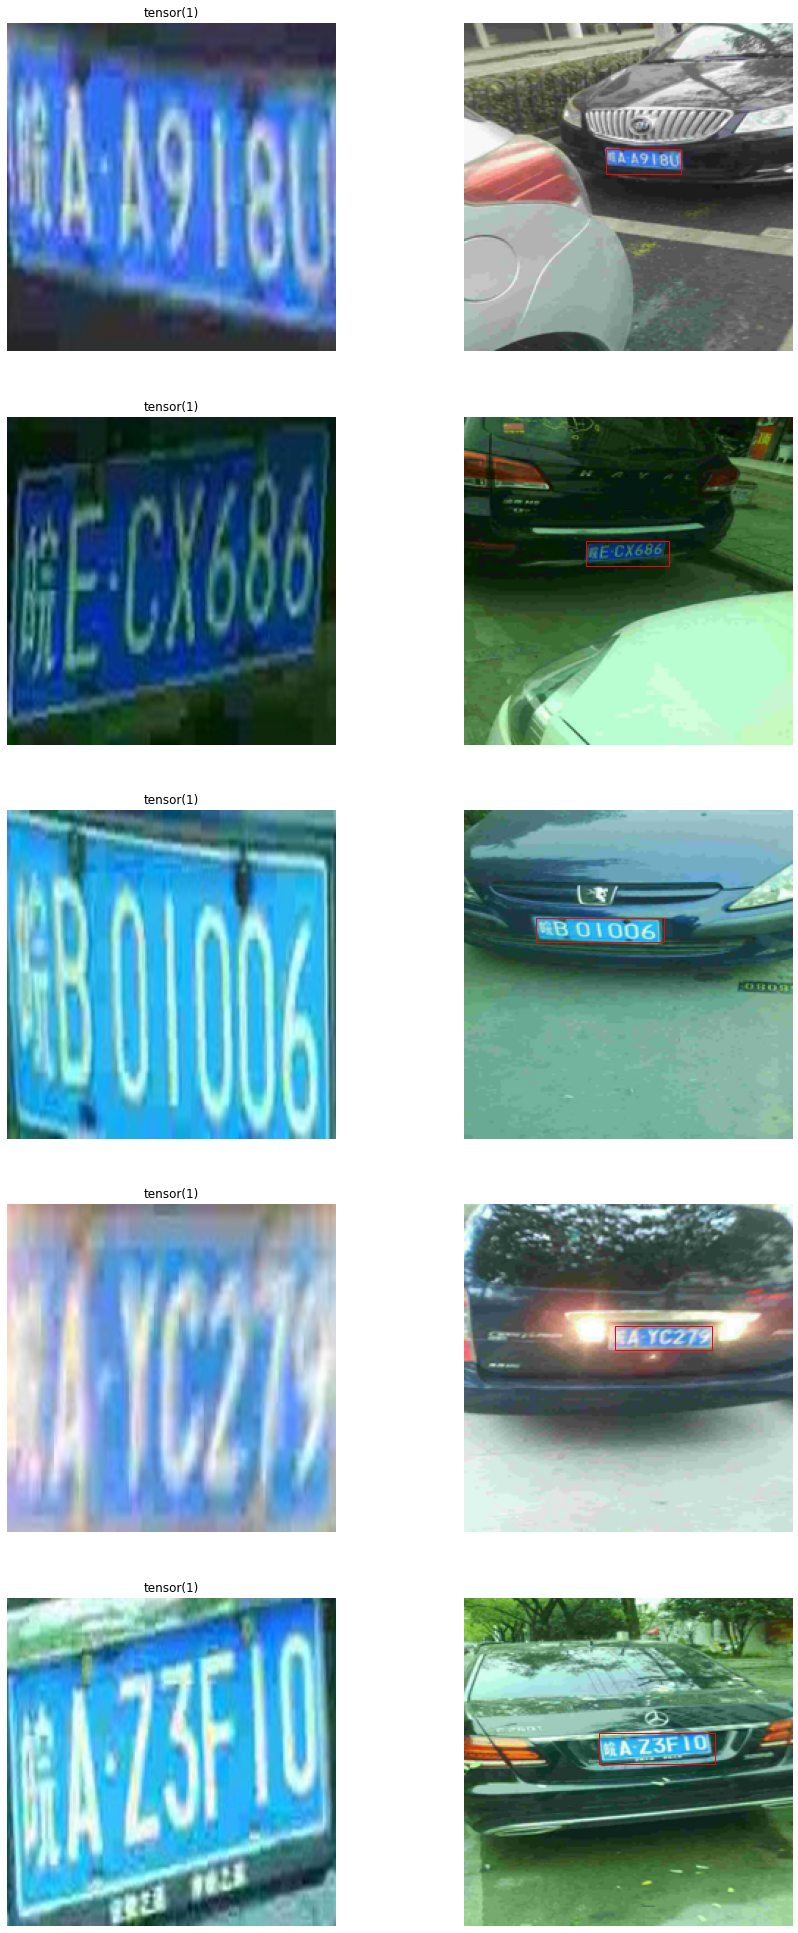

In [4]:
from IPython.display import clear_output
import time
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

carplate_root = "./data/data-carplate"
carplate_anno = "annotations.json"

batch_train = 16
batch_valid = 1

dataset = CarPlateDataset(carplate_root, carplate_anno, feature_extractor, dataset_size=DATASET_SIZE, use_random_template=False, img_size=(224, 224))
DATASET_SIZE = dataset.dataset_size
train_size = int(DATASET_SIZE * 0.8)
valid_size = DATASET_SIZE - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_train, shuffle=True, num_workers=1)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_valid, shuffle=False, num_workers=1)

see_examples = 5
fig = plt.figure(figsize=(15, 7*see_examples))
for i, (imgs, temp, similarity, coordinates) in enumerate(train_dataloader):
    clear_output(wait=True)
    imgs = np.transpose(imgs, (0, 2, 3, 1))
    temp = np.transpose(temp, (0, 2, 3, 1))
    fig.add_subplot(see_examples, 2, i * 2 + 1)
    plt.title(similarity[0])
    plt.axis('off')
    plt.imshow(temp[0])
   
    fig.add_subplot(see_examples, 2, i * 2 + 2)
    
    plt.axis('off')
    plt.imshow(imgs[0])

    x1, y1, x2, y2 = coordinates[0]
    x1 = x1 * dataset.img_size[1]
    y1 = y1 * dataset.img_size[0]
    x2 = x2 * dataset.img_size[1]
    y2 = y2 * dataset.img_size[0]

    rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    

    if i >= see_examples - 1:
      break
plt.show()


In [5]:
from transformers import ViTForImageClassification, ViTConfig, ViTModel

# vit_config = ViTConfig(hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5)

# vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
#                                                       num_labels=len(category2id),
#                                                       id2label=id2category,
#                                                       label2id=category2id)
vit_backbone_image = ViTModel.from_pretrained('google/vit-base-patch16-224')
# vit_backbone_template = ViTModel.from_pretrained('google/vit-base-patch16-384')

for param in vit_backbone_image.embeddings.parameters():
    param.requires_grad = False
for layer in vit_backbone_image.encoder.layer[:NUM_LAYERS_FROZEN]:
    print(layer)
    for param in layer.parameters():
        param.requires_grad = False
        
# for param in vit_backbone_template.embeddings.parameters():
#     param.requires_grad = False
# for layer in vit_backbone_template.encoder.layer[:NUM_LAYERS_FROZEN]:
#     print(layer)
#     for param in layer.parameters():
#         param.requires_grad = False

# print(vit_model)
# print(vars(vit_backbone))

class SiameseTransformerViT(nn.Module):
    def __init__(self, backbone_image):
        super(SiameseTransformerViT, self).__init__()
        self.backbone_image = backbone_image
        # self.backbone_template = backbone_template
    
        self.bounding_box = nn.Sequential(
            nn.Linear(backbone_image.config.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 4),
        )
    def forward_once(self, x):
        x = self.backbone_image(x)
        x = x.last_hidden_state[:, 0, :]
        return x
        

    def forward(self, image, template):
        image_features = self.forward_once(image)
        template_features = self.forward_once(template)
        similarity = nn.functional.cosine_similarity(image_features, template_features)
        bbox_prediction = self.bounding_box(torch.cat([image_features, template_features], 1))
        # features = features.last_hidden_state[:, 0, :]
        # print(features[:, 0, :].shape)
        return image_features, template_features, similarity, bbox_prediction

vit_model = SiameseTransformerViT(vit_backbone_image)


Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTLayer(
  (attention): ViTAttention(
    (attention): ViTSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): ViTSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (intermediate): ViTIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): ViTOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)
ViTLayer(
  (attention): ViTAttention(
    (attention): ViTSelfAttention(
 

In [6]:
def calculate_iou_acc(iou_list, counter):
    iou_list_50 = (iou_list > 0.5).sum()
    iou_list_75 = (iou_list > 0.75).sum()
    iou_list_90 = (iou_list > 0.90).sum()
    return [iou_list_50 / counter, iou_list_75 / counter, iou_list_90 / counter]

def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def train_epoch(model, train_dataloader, loss_bounding_box, optimizer, device):
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    IOU_list = []
    labels = []
    images = []
    templates = []
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_images, batch_templates, batch_similarities, batch_bboxs = batch
        batch_images = batch_images.to(device)
        batch_templates = batch_templates.to(device)
        # batch_similarities = batch_similarities.to(device)
        batch_bboxs = batch_bboxs.to(device)

        image_features, template_features, predicted_similarities, predicted_bboxs = model(batch_images, batch_templates)
        
        loss = loss_bounding_box(predicted_bboxs, batch_bboxs)

        loss_scalar = loss.item()

        # if idx % 150 == 0:
        #     print(epoch_acc/(idx + 1))
        #     print(batch_predictions)

        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=1.5
        )

        model.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss_scalar
        
        bbox_pred = predicted_bboxs.detach().cpu().numpy()
        bbox_original = batch_bboxs.cpu().numpy()

        images.append(batch_images[0].cpu())
        templates.append(batch_templates[0].cpu())
        labels.append(bbox_original[0])
        predictions.append(bbox_pred[0])
        IOU_list.append(bb_intersection_over_union(bbox_pred[0], bbox_original[0]))

    all_data = {
        'images': images,
        'templates': templates,
        'labels': labels,
        'predictions': predictions
    }
    epoch_loss = epoch_loss/num_batches
    IOU_list = np.array(IOU_list)

    return epoch_loss, IOU_list, labels, predictions, all_data


def eval_epoch(model, val_dataloader, loss_bounding_box, device):
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    IOU_list = []
    predictions = []
    images = []
    templates = []
    labels = []
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(val_dataloader)):
            batch_images, batch_templates, batch_similarities, batch_bboxs = batch
            batch_images = batch_images.to(device)
            batch_templates = batch_templates.to(device)
            # batch_similarities = batch_similarities.to(device)
            batch_bboxs = batch_bboxs.to(device)

            image_features, template_features, predicted_similarities, predicted_bboxs = model(batch_images, batch_templates)

            loss = loss_bounding_box(predicted_bboxs, batch_bboxs)

            loss_scalar = loss.item()

            epoch_loss += loss_scalar

            bbox_pred = predicted_bboxs.detach().cpu().numpy()
            bbox_original = batch_bboxs.cpu().numpy()
            images.append(batch_images[0].cpu())
            templates.append(batch_templates[0].cpu())
            labels.append(bbox_original[0])
            predictions.append(bbox_pred[0])

            IOU_list.append(bb_intersection_over_union(bbox_pred[0], bbox_original[0]))

        epoch_loss = epoch_loss/num_batches
        IOU_list = np.array(IOU_list)
        all_data = {
            'images': images,
            'templates': templates,
            'labels': labels,
            'predictions': predictions
        }

    return epoch_loss, IOU_list, labels, predictions, all_data



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# move the model to GPU (when available)
vit_model.to(device)

# create a SGD optimizer
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(vit_model.parameters(), lr=1e-3, momentum=0.9)
# optimizer = torch.optim.Adam(vit_model.parameters(), lr=2e-5)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=1e-2, verbose=True)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
#
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=1e-3, verbose=True)

# set up loss function
loss_criterion = nn.MSELoss()

train_losses = []
train_accuracies = []
train_iou = []
val_losses = []
val_accuracies = []
val_iou =[]
for epoch in range(1, EPOCHS+1):
    train_loss, train_IOU_data, train_bboxes, train_predicted_bboxes, train_all_data = train_epoch(vit_model, train_dataloader, loss_criterion, optimizer, device)
    val_loss, val_IOU_data, val_bboxes, val_predicted_bboxes, val_all_data = eval_epoch(vit_model, valid_dataloader, loss_criterion, device)
    train_IOU_data = calculate_iou_acc(train_IOU_data, len(train_dataloader))
    val_IOU_data = calculate_iou_acc(val_IOU_data, len(valid_dataloader))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # train_accuracies.append(train_accuracy)
    # val_accuracies.append(val_accuracy)
    train_iou.append(train_IOU_data)
    val_iou.append(val_IOU_data)
    print('\nEpoch %d'%(epoch))
    print('train loss: %10.8f'%(train_loss))
    print(f"train IOU 50% accuracy: {train_IOU_data[0]}")
    print(f"train IOU 75% accuracy: {train_IOU_data[1]}")
    print(f"train IOU 90% accuracy: {train_IOU_data[2]}")
    print('val loss: %10.8f'%(val_loss))
    print(f"val IOU 50% accuracy: {val_IOU_data[0]}")
    print(f"val IOU 75% accuracy: {val_IOU_data[1]}")
    print(f"val IOU 90% accuracy: {val_IOU_data[2]}")


cuda


250it [01:29,  2.80it/s]
1000it [00:33, 29.85it/s]


Epoch 1
train loss: 0.01455356
train IOU 50% accuracy: 0.972
train IOU 75% accuracy: 0.632
train IOU 90% accuracy: 0.064
val loss: 0.00791100
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.783
val IOU 90% accuracy: 0.118



250it [01:27,  2.85it/s]
1000it [00:30, 32.53it/s]


Epoch 2
train loss: 0.00711793
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.784
train IOU 90% accuracy: 0.112
val loss: 0.00546809
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.86
val IOU 90% accuracy: 0.237



250it [01:28,  2.84it/s]
1000it [00:30, 32.69it/s]


Epoch 3
train loss: 0.00599472
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.828
train IOU 90% accuracy: 0.2
val loss: 0.00510150
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.896
val IOU 90% accuracy: 0.292



250it [01:27,  2.87it/s]
1000it [00:27, 35.97it/s]


Epoch 4
train loss: 0.00505212
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.888
train IOU 90% accuracy: 0.22
val loss: 0.00403840
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.92
val IOU 90% accuracy: 0.401



250it [01:31,  2.74it/s]
1000it [00:43, 22.87it/s]



Epoch 5
train loss: 0.00404089
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.924
train IOU 90% accuracy: 0.26
val loss: 0.00407497
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.912
val IOU 90% accuracy: 0.302


250it [01:30,  2.75it/s]
1000it [00:32, 31.06it/s]


Epoch 6
train loss: 0.00310792
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.94
train IOU 90% accuracy: 0.352
val loss: 0.00377647
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.936
val IOU 90% accuracy: 0.38



250it [01:33,  2.68it/s]
1000it [00:31, 31.60it/s]



Epoch 7
train loss: 0.00256595
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.976
train IOU 90% accuracy: 0.436
val loss: 0.00295744
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.959
val IOU 90% accuracy: 0.457


250it [01:30,  2.77it/s]
1000it [00:29, 34.16it/s]


Epoch 8
train loss: 0.00223724
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.956
train IOU 90% accuracy: 0.464
val loss: 0.00269765
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.96
val IOU 90% accuracy: 0.475



250it [01:28,  2.83it/s]
1000it [00:28, 35.25it/s]


Epoch 9
train loss: 0.00204138
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.988
train IOU 90% accuracy: 0.592
val loss: 0.00386103
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.942
val IOU 90% accuracy: 0.323



250it [01:27,  2.87it/s]
1000it [00:28, 34.98it/s]


Epoch 10
train loss: 0.00176933
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.996
train IOU 90% accuracy: 0.608
val loss: 0.00266579
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.962
val IOU 90% accuracy: 0.491


In [8]:
try:
    os.makedirs(data_saved_path)
    os.makedirs(model_save_path)
except:
    print("Directory already exists")


In [9]:
# save model
torch.save(vit_model.state_dict(), os.path.join(model_save_path, "base_model_weights.pt"))


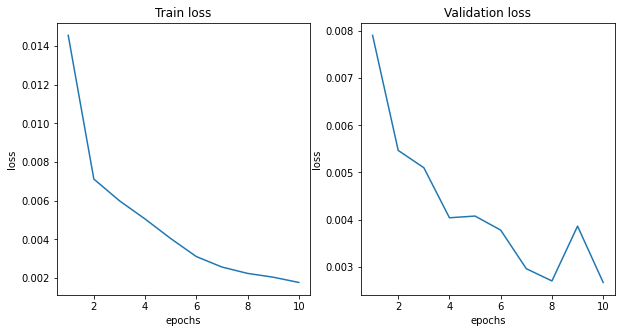

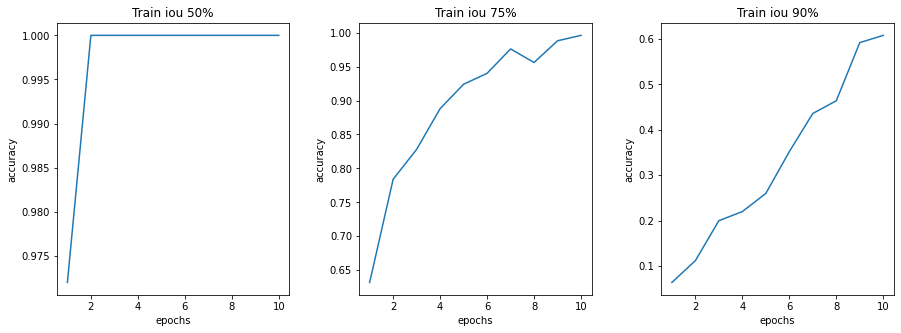

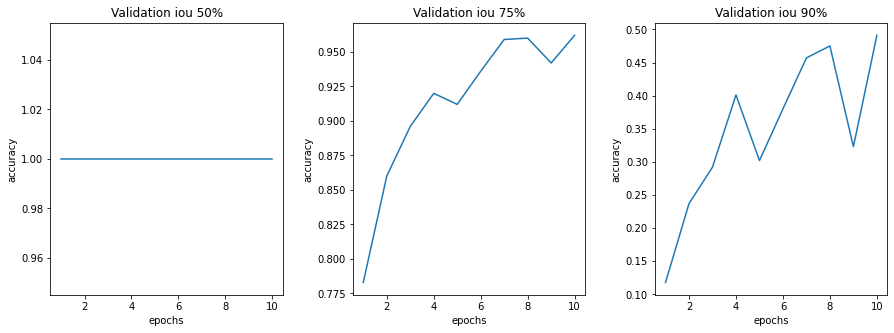

In [10]:
# train plots
epoch_list = np.arange(1, EPOCHS + 1, 1)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(epoch_list, train_losses)
axs[0].set_title('Train loss')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[1].plot(epoch_list, val_losses)
axs[1].set_title('Validation loss')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
plt.subplots_adjust(wspace=0.2)
plt.savefig(os.path.join(data_saved_path, 'loss_plots.png'))
plt.show()

train_iou = np.array(train_iou)
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(epoch_list, train_iou[:, 0])
axs[0].set_title('Train iou 50%')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[1].plot(epoch_list, train_iou[:, 1])
axs[1].set_title('Train iou 75%')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[2].plot(epoch_list, train_iou[:, 2])
axs[2].set_title('Train iou 90%')
axs[2].set_xlabel('epochs')
axs[2].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.3)
plt.savefig(os.path.join(data_saved_path, 'train_iou.png'))
plt.show()

val_iou = np.array(val_iou)
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(epoch_list, val_iou[:, 0])
axs[0].set_title('Validation iou 50%')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[1].plot(epoch_list, val_iou[:, 1])
axs[1].set_title('Validation iou 75%')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[2].plot(epoch_list, val_iou[:, 2])
axs[2].set_title('Validation iou 90%')
axs[2].set_xlabel('epochs')
axs[2].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.3)
plt.savefig(os.path.join(data_saved_path, 'validation_iou.png'))
plt.show()



In [11]:
def plot_random_samples(images, templates, labels, predictions, image_size=(224,224), number_samples=5, name='train_results.png'):
    fig = plt.figure(figsize=(20, 7*see_examples))
    for i in range(number_samples):
        index = np.random.randint(len(labels))
        img = images[index].cpu()
        temp = templates[index].cpu()
        label = labels[index]
        prediction = predictions[index]
        # clear_output(wait=True)
        img = np.transpose(img, (1, 2, 0))
        temp = np.transpose(temp, (1, 2, 0))
        fig.add_subplot(see_examples, 3, i * 3 + 1)
        plt.title("Template")
        plt.axis('off')
        plt.imshow(temp)


        l_x1, l_y1, l_x2, l_y2 = label
        l_x1 = l_x1 * image_size[1]
        l_y1 = l_y1 * image_size[0]
        l_x2 = l_x2 * image_size[1]
        l_y2 = l_y2 * image_size[0]

        x1, y1, x2, y2 = prediction
        x1 = x1 * image_size[1]
        y1 = y1 * image_size[0]
        x2 = x2 * image_size[1]
        y2 = y2 * image_size[0]

        fig.add_subplot(see_examples, 3, i * 3 + 2)
        plt.axis('off')
        plt.title(f'xmin={l_x1} ymin={l_y1}\nxmax={l_x2} ymax={l_y2}')
        # plt.title(label)
        plt.imshow(img)
        rect = patches.Rectangle((l_x1,l_y1),l_x2-l_x1+1,l_y2-l_y1+1,linewidth=1,edgecolor='r',facecolor='none')
        plt.gca().add_patch(rect)

        fig.add_subplot(see_examples, 3, i * 3 + 3)
        plt.axis('off')
        plt.title(f'xmin={x1} ymin={y1}\nxmax={x2} ymax={y2}')
        plt.imshow(img)
        rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
        plt.gca().add_patch(rect)

    plt.savefig(os.path.join(data_saved_path, name))
    plt.show()


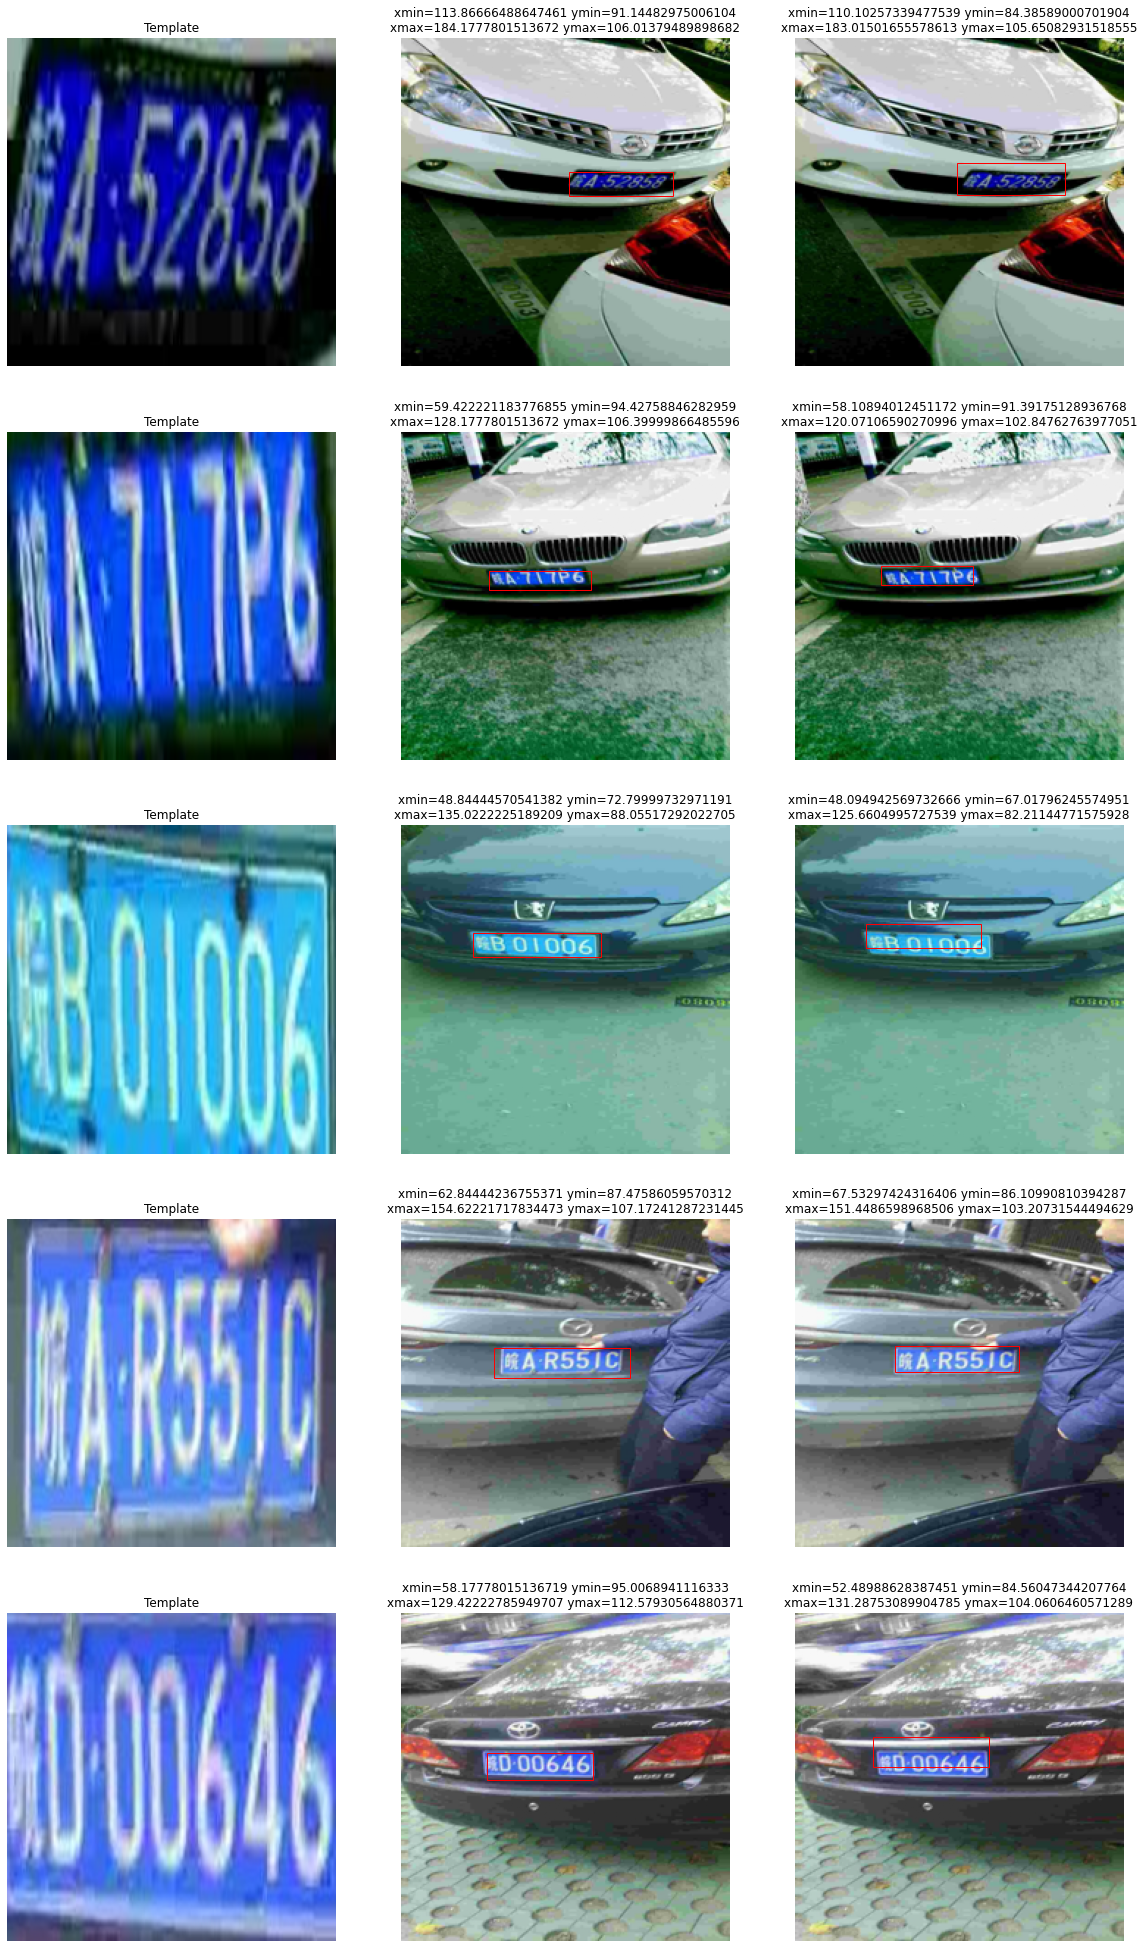

In [12]:
plot_random_samples(train_all_data['images'], train_all_data['templates'], train_all_data['labels'], train_all_data['predictions'])


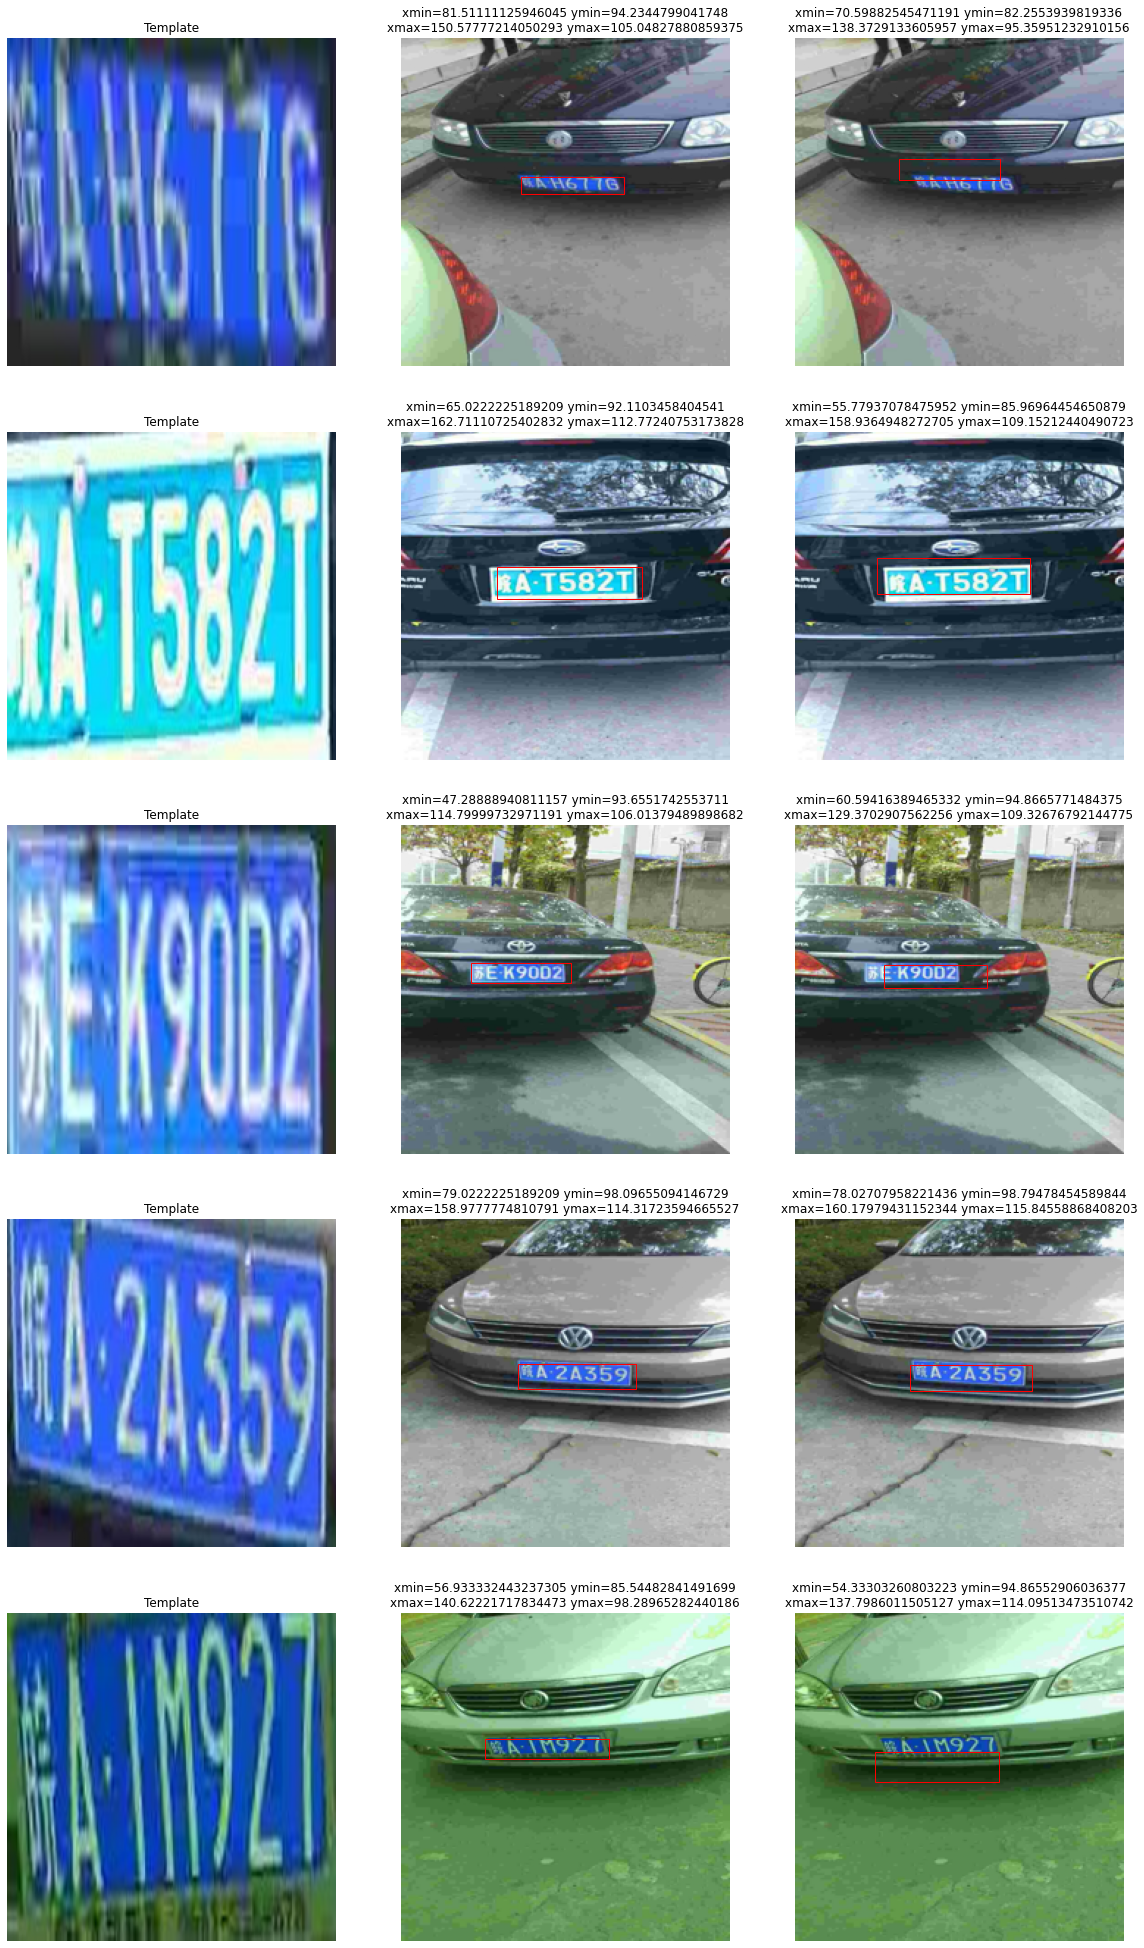

In [18]:
plot_random_samples(val_all_data['images'], val_all_data['templates'], val_all_data['labels'], val_all_data['predictions'], name='validation_results.png')


In [16]:
data_dataframe = pd.DataFrame({
    'epochs': epoch_list,
    'train_loss': train_losses,
    'train_iou_50%': train_iou[:, 0],
    'train_iou_75%': train_iou[:, 1],
    'train_iou_90%': train_iou[:, 2],
    'val_loss': val_losses,
    'val_iou_50%': val_iou[:, 0],
    'val_iou_75%': val_iou[:, 1],
    'val_iou_90%': val_iou[:, 2]
})
data_dataframe.to_csv(os.path.join(data_saved_path, "training_data.csv"))
